# 551 Lec 7 - Tables, styling, performance

You need to download this notebook to view images.

## Lecture learning goals

By the end of the lecture you will be able to:

1. Create dash tables
2. Use interactive dash table components in callbacks
3. More readily implement best practices discussed before for layout and titles
4. Cache callback values of expensive computations
5. Recognize performance tweaks for plots such as WebGL, and datashader

-------

## Dash tables

### Creating tables with pagination, filters and sorting

Dash has tables that can filter and sort data,
as well as send and respond to signals.
let's see how to create them!

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
            ),
        ])
    ])
)

if __name__ == '__main__':
    app.run_server(debug=True)
```

We only pass the five first columns of the data frame to make it a bit easier to look at for our purposes.
In general,
we probably don't want to display massive amounts of data in this manner anyways.

![](images/7/7.01.png)


Instead of viewing all the data in one long table,
we can enable pagination by specifying e.g. `page_size=10`.

![](images/7/7.02.png)


We can enable sorting by setting `sort_action='native'`,
which gives us small arrows to the click on the left side of each column header.

![](images/7/7.03.png)

Filtering can be enabled in the same manner 
by setting `filter_action='native'`.
[Dash has it own filter syntax](https://dash.plotly.com/datatable/filtering),
which is similar to what we have used previously with dataframes.

![](images/7/7.04.png)

To make columns selectable
with a radio button,
we need to add three lines
(also showing how to avoid making all columns selectable,
we're skipping `'name'` here:

```python
columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]],  
column_selectable="single",
selected_columns=['Miles_per_Gallon'], 
```
![](images/7/7.05.png)

Finally,
we can make our table a bit prettier
by styling it with the following segment,
which color the rows in alternating dark and light colors.

```python
style_cell={'padding': '5px'},
style_data_conditional=[{
    'if': {'row_index': 'odd'},
    'backgroundColor': 'rgb(248, 248, 248)'}],
 style_header={
    'backgroundColor': 'rgb(230, 230, 230)',
    'fontWeight': 'bold'}
```


![](images/7/7.06.png)

Our entire app now looks like this:

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]],  
                data=cars.to_dict('records'),
                sort_action="native",
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size=10,
                filter_action='native',
                style_cell={'padding': '5px'},
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}
            ),
        ])
    ])
)

if __name__ == '__main__':
    app.run_server(debug=True)
```

### Table callbacks

Tables have several emitted signals/events that we can listen for,
the most relevant in our case are the rows which change when we filter,
and the column that is selected.
First we add an empty div as a placeholder for the output area,
but we will not use it in the beginning.
Instead,
let's just print the value
which will show you that a list of columns is always returned.

```python
@app.callback(
    Output('output-div', "children"),
    Input('table', "selected_columns"))
def update_graphs(selected_column):
    print(selected_column)
```

The other intersting signal,
the rows of the table,
are a bit more cryptically named (`'derived_virtual_data'`).

```python
@app.callback(
    Output('output-div', "children"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_graphs(rows, selected_column):
    print(rows)
```

When we print the `rows`, 
you can see that the format is a list with one dictionary per row.
To get this back to a dataframe,
we will use `pd.DataFrame(rows)`.
If you try filtering,
you will see that fewer rows are returned here.

### Controlling plots from the table callback

We can now use these callbacks to drive plotting events,
just as we would have if we had used a dash core components widget.
The following would plot a histogram of the selected column and the filtered data points:

```python
# An Iframe with the 'histogram' ID is also needed

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_graphs(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    return chart.to_html()
```

Here is the entire app when plotting both a histogram and scatter plot
based on the state of the table.

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
                style_cell={'padding': '5px'},
                sort_action="native",
                page_action='native',
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size= 10,
                filter_action='native',
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}),
            html.Div(id='output-div'),
            html.Iframe(
                id='histogram',
                style={'border-width': '0', 'width': '100%', 'height': '400px'}
            )
        ])
    ])
)

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_graphs(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    chart2 = alt.Chart(pd.DataFrame(rows)).mark_point().encode(
        alt.X(selected_column[0]),
        alt.Y('Horsepower'),
        tooltip='Name')
    return (chart | chart2).to_html()

if __name__ == '__main__':
    app.run_server(debug=True
```

![](images/7/7.07.png)

## Updating a table based on a callback

For callbacks from other widgets or from plotly plots,
you can treat tables as any other output element
and target their `columns` and `data` attributes to update them
via a callback function.

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_core_components as dcc
from dash.dependencies import Output, Input
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(id='table', page_size=5),
            dcc.Dropdown(
                id='dropdown',
                options=[{"label": col, "value": col} for col in cars.columns],
                multi=True,
                value=['Horsepower']
            ),
        ])
    ])
)

@app.callback(
    Output('table', 'data'),
    Output('table', 'columns'),
    Input('dropdown', 'value'))
def update_table(cols):
    columns=[{"name": col, "id": col} for col in cols]
    data=cars[cols].to_dict('records')
    return data, columns

if __name__ == '__main__':
    app.run_server(debug=True)
```

![](images/7/7.08.png)

### Updating a table from an Altair plot

From altair plots,
there is no way to update a dash table,
but if you just need to show a few numbers based on a plot selection,
you can [use `mark_text()`
to update a plot area that looks like a table](https://altair-viz.github.io/gallery/scatter_linked_table.html).

In [1]:
import altair as alt
from vega_datasets import data

source = data.cars()

# Brush for selection
brush = alt.selection(type='interval')

# Scatter Plot
points = alt.Chart(source).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=alt.condition(brush, alt.value('steelblue'), alt.value('grey'))
).add_selection(brush)

# Base chart for data tables
ranked_text = alt.Chart(source).mark_text(align='right').encode(
    y=alt.Y('row_number:O',axis=None)
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    alt.datum.rank<16
)

# Data Tables
horsepower = ranked_text.encode(text='Horsepower:N').properties(title=alt.TitleParams(text='Horsepower', align='right'))
mpg = ranked_text.encode(text='Miles_per_Gallon:N').properties(title=alt.TitleParams(text='MPG', align='right'))
origin = ranked_text.encode(text='Origin:N').properties(title=alt.TitleParams(text='Origin', align='right'))
text = alt.hconcat(horsepower, mpg, origin) # Combine data tables

# Build chart
alt.hconcat(
    points,
    text
).resolve_legend(
    color="independent"
).configure_view(strokeWidth=0)

alt.HConcatChart(...)

## Dash data tables in R

In R, we use `purrr` similar to how we did in a dropdown for creating the columns
and the function `df_to_list` from `dashTable` to convert the dataframe to a dash table friendly format.

```R
library(dash)
library(dashTable)
library(dplyr)

msleep <- ggplot2::msleep

app <- Dash$new()

app$layout(
    dashDataTable(
        id = "table",
        columns = msleep %>%
            colnames %>%
            purrr::map(function(col) list(name = col, id = col)),
        data = df_to_list(msleep),
        page_size = 5
    )
)
```

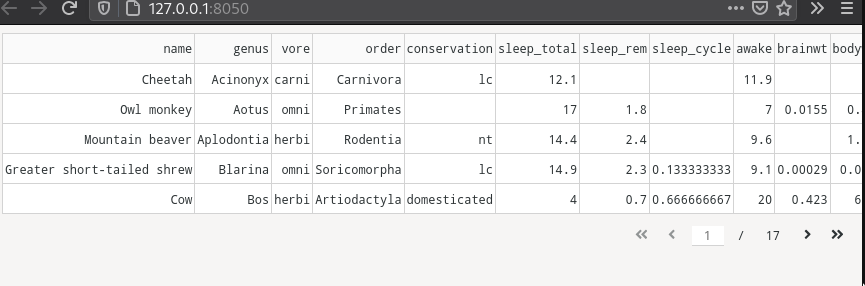
![](images/7/7.09.png)

### Data Table callbacks in R

The most unusual aspect of this callback is the use of `unlist()`
to convert the list of column names into a vector of column names
that is valid for indexing the dataframe.

```
library(dash)
library(dashTable)
library(dplyr)
library(dashCoreComponents)
library(dashBootstrapComponents)

msleep <- ggplot2::msleep

app <- Dash$new(external_stylesheets = dbcThemes$BOOTSTRAP)

app$layout(
    dbcContainer(
        dbcCol(list(
            dashDataTable(
                id = "table",
                page_size = 5),
            dccDropdown(
                id = 'dropdown',
                    options = msleep %>% 
                    colnames %>% 
                    purrr::map(function(col) list(label = col, value = col)),
                multi = T,
                value = list('name'))
            )
        )
    )
)

app$callback(
    list(output('table', 'data'),
         output('table', 'columns')),
    list(input('dropdown', 'value')),
    function(cols) {
        columns <- cols %>%
            purrr::map(function(col) list(name = col, id = col))
        data <- df_to_list(msleep %>% select(unlist(cols)))
        print(columns)
        list(data, columns)
    }
)

app$run_server(debug = T)
```

![](images/7/7.10.png)

## Styling

### Setting plot titles via cards

You can also put local widgets inside these cards to clearly separate them from the global widgets
and to indicate which plot they control.

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
                style_cell={'padding': '5px'},
                sort_action="native",
                page_action='native',
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size= 10,
                filter_action='native',
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}),
            html.Br(),
            html.Br(),
            html.Br(),
            dbc.Row([
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Variable distrbution'),
                        dbc.CardBody(
                            html.Iframe(
                                id='histogram',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])]),
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Relation to Horsepower'),
                        dbc.CardBody(
                            html.Iframe(
                                id='scatter',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])])
            ])
        ])
    ])
)

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_histogram(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    return chart.properties(width=320, height=320).to_html()

@app.callback(
    Output('scatter', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_scatter(rows, selected_column):
    chart2 = alt.Chart(pd.DataFrame(rows)).mark_point().encode(
        alt.X(selected_column[0]),
        alt.Y('Horsepower'),
        tooltip='Name')
    return chart2.properties(width=320, height=320).to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```

![](images/7/7.11.png)

## Creating an appealing dashboard title

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            # dbc.Jumbotron(dbc.Container(html.H1('Layout demo', className='display-3'), fluid=True), fluid=True),
            html.H1('My splashboard demo',
                style={
                    'backgroundColor': 'steelblue',
                    'padding': 20,
                    'color': 'white',
                    'margin-top': 20,
                    'margin-bottom': 20,
                    'text-align': 'center',
                    'font-size': '48px',
                    'border-radius': 3}), #, 'width': 300}),
            # jumbotron,
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
                style_cell={'padding': '5px'},
                sort_action="native",
                page_action='native',
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size= 10,
                filter_action='native',
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}),
            html.Br(),
            html.Br(),
            html.Br(),
            dbc.Row([
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Variable distrbution', style={'fontWeight': 'bold'}),
                        dbc.CardBody(
                            html.Iframe(
                                id='histogram',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])]),
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Relation to Horsepower', style={'fontWeight': 'bold'}),
                        dbc.CardBody(
                            html.Iframe(
                                id='scatter',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])])
            ])
        ])
    ])
)

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_histogram(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    return chart.properties(width=320, height=320).to_html()

@app.callback(
    Output('scatter', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_scatter(rows, selected_column):
    chart2 = alt.Chart(pd.DataFrame(rows)).mark_point().encode(
        alt.X(selected_column[0]),
        alt.Y('Horsepower'),
        tooltip='Name')
    return chart2.properties(width=320, height=320).to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```

![](images/7/7.12.png)

### Adding a sidebar for global widgets

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1('My splashboard demo',
                style={
                    'color': 'white',
                    'text-align': 'left',
                    'font-size': '48px',
                    }) #, 'width': 300}),

        ], style={'backgroundColor': 'steelblue',
                    'border-radius': 3,
                    'padding': 15,
                    'margin-top': 20,
                    'margin-bottom': 20,
                    'margin-right': 15
        })
                    
    ]),
    dbc.Row([
        dbc.Col([
            html.H5('Global controls'),
            html.Br(),
            dcc.Dropdown(),
            html.Br(),
            dcc.Dropdown(),
            html.Br(),
            dcc.Dropdown(),
            html.Br(),
            dcc.Dropdown(),
            ],
            md=2,
            style={
                'background-color': '#e6e6e6',
                'padding': 15,
                'border-radius': 3}), 
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
                style_cell={'padding': '5px'},
                sort_action="native",
                page_action='native',
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size= 10,
                filter_action='native',
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}),
            html.Br(),
            html.Br(),
            html.Br(),
            dbc.Row([
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Variable distrbution', style={'fontWeight': 'bold'}),
                        dbc.CardBody(
                            html.Iframe(
                                id='histogram',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])]),
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Relation to Horsepower', style={'fontWeight': 'bold'}),
                        dbc.CardBody(
                            html.Iframe(
                                id='scatter',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])])
            ])
        ])
    ]),
    html.Hr(),
    html.P('This dashboard was made by Joel, link to GitHub source. The data is from here and there (include links if appropriate), some copyright/license info')
])

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_histogram(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    return chart.properties(width=320, height=320).to_html()

@app.callback(
    Output('scatter', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_scatter(rows, selected_column):
    chart2 = alt.Chart(pd.DataFrame(rows)).mark_point().encode(
        alt.X(selected_column[0]),
        alt.Y('Horsepower'),
        tooltip='Name')
    return chart2.properties(width=320, height=320).to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```

![](images/7/7.13.png)

## Adding introductory text and references to code and data

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Output, Input, State
from datetime import datetime
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

collapse = html.Div(
    [
        dbc.Button(
            "Learn more",
            id="collapse-button",
            className="mb-3",
            outline=False,
            style={'margin-top': '10px',
                'width': '150px',
                'background-color': 'white',
                'color': 'steelblue'}
        ),
    ]
)


@app.callback(
    Output("collapse", "is_open"),
    [Input("collapse-button", "n_clicks")],
    [State("collapse", "is_open")],
)
def toggle_collapse(n, is_open):
    if n:
        return not is_open
    return is_open

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            dbc.Row([
            dbc.Col([
                html.H1('My splashboard demo',
                    style={
                        'color': 'white',
                        'text-align': 'left',
                        'font-size': '48px',  #, 'width': 300}),
                        }),
               dbc.Collapse(
                    html.P("""
                        This dashboard is helping you understand x, y, and z, 
                        which are really important because a, b, c.
                        Start using the dashboard by clicking on 1, 2, 3
                        and pulling i, ii, and iii.""",
                        style={'color': 'white', 'width': '50%'}),
                    id="collapse",
        ),

                    ],
                    md=10),
                dbc.Col([collapse])

                
            ])
        ], style={'backgroundColor': 'steelblue',
                    'border-radius': 3,
                    'padding': 15,
                    'margin-top': 20,
                    'margin-bottom': 20,
                    'margin-right': 15
        })
                    
    ]),
    dbc.Row([
        dbc.Col([
            html.H5('Global controls'),
            html.Br(),
            dcc.Dropdown(),
            html.Br(),
            dcc.Dropdown(),
            html.Br(),
            dcc.Dropdown(),
            html.Br(),
            dcc.Dropdown(),
            ],
            md=2,
            style={
                'background-color': '#e6e6e6',
                'padding': 15,
                'border-radius': 3}), 
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
                style_cell={'padding': '5px'},
                sort_action="native",
                page_action='native',
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size= 10,
                filter_action='native',
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}),
            html.Br(),
            html.Br(),
            html.Br(),
            dbc.Row([
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Variable distrbution', style={'fontWeight': 'bold'}),
                        dbc.CardBody(
                            html.Iframe(
                                id='histogram',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])]),
                dbc.Col([
                    dbc.Card([
                        dbc.CardHeader('Relation to Horsepower', style={'fontWeight': 'bold'}),
                        dbc.CardBody(
                            html.Iframe(
                                id='scatter',
                                style={'border-width': '0', 'width': '100%', 'height': '400px'}))])])
            ])
        ])
    ]),
    html.Hr(),
    html.P(f'''
    This dashboard was made by Joel, link to GitHub source.
    The data is from here and there (include links if appropriate), some copyright/license info
    Mention when the dashboard was latest updated (and data if appropriate).
    This will show the date when you last resarted the server: {datetime.now().date()}
    ''')
])
@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_histogram(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    return chart.properties(width=300, height=300).to_html()

@app.callback(
    Output('scatter', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_scatter(rows, selected_column):
    chart2 = alt.Chart(pd.DataFrame(rows)).mark_point().encode(
        alt.X(selected_column[0]),
        alt.Y('Horsepower'),
        tooltip='Name')
    return chart2.properties(width=300, height=300).to_html()

if __name__ == '__main__':
    app.run_server(debug=True)
```

![](images/7/7.14.png)

## Performance

### Loading data from binary formats

If you initial load times are slow,
consider storing the processed data (still keep a copy of the raw)
as a binary file format.
[According to the pandas docs,
feather and hdf5 are the fastest](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#performance-considerations).
If you have complex data structures like nested lists,
these might not work,
but saving to a `pickle` (Python's native binary format)
still should and is also very fast.

When working with `altair` and large data sets,
you can enable the altair data server like we did in 531
in order to avoid writing all the data to each plot's json 
which can take a long time.
[Uploading it to your server as a compatible json format (`data.to_json(path, orient='records'`)
and reading directly from that path/URL is also a good approach](https://altair-viz.github.io/user_guide/faq.html?highlight=url#why-does-altair-lead-to-such-extremely-large-notebooks).

### Caching/memoization

If we have a time consuming computation step that generates an output,
we can save that output to the file system (or a database)
so that next time we don't have to compute it again but just read it in.
Trading space for time like this
is called chaching or memoization.

First let's create an app that simulates a timeconsuming step,
by sleeping the process for a few seconds between each call.
Every time we select from the dropdown menu,
this app will do the time consuming process of reading in the data again,
so we have to wait a couple of seconds for the output to refresh.
If we look at the timestamp in the `time` column,
we can see that it is always the same
as the current time
(because it is rerun each time the dropdown changes).

```python
import time
from datetime import datetime

import dash
import dash_core_components as dcc
import dash_html_components as html
import numpy as np
import pandas as pd
from dash.dependencies import Input, Output

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

def query_data():
    # Simulate a time consuming step with sleep
    time.sleep(2)
    df = pd.DataFrame(
        np.random.randint(0, 100, size=(100, 4)),
        columns=list('ABCD'))
    df['time'] = datetime.now().strftime('%H:%M:%S')
    return df.to_json(date_format='iso', orient='split')


def dataframe():
    return pd.read_json(query_data(), orient='split')

app.layout = html.Div([
    html.H6(id='current-time'),
    dcc.Dropdown(
        id='live-dropdown',
        value='A',
        options=[{'label': i, 'value': i} for i in dataframe().columns]),
    html.Iframe(
        id='output-area',
        style={'border-width': '0', 'width': '100%', 'height': '400px'})])


@app.callback(Output('output-area', 'srcDoc'),
              Output('current-time', 'children'),
              Input('live-dropdown', 'value'))
def update_live_graph(col):
    print(col)
    df = dataframe()
    current_time = f"The current time is {datetime.now().strftime('%H:%M:%S')}"
    return df[[col]].to_html(index=False), current_time

if __name__ == '__main__':
    app.run_server(debug=True)
```

![](images/7/7.15.png)

Ideally,
we would do most of our timeconsuming wrangling in the beginning when the page load
or even better,
beforehand and save a processed dataset,
but there might be some wrangling or other time consuming process that can't be avoided.
Often we don't need these process to update each time a selection is made,
and we would be fine reusing the data from the selection made a few seconds ago.
We can set this up using the [flask-caching](https://flask-caching.readthedocs.io/en/latest/) package
(`conda install flask-caching`) like this:

```python
from flask_caching import Cache


cache = Cache(app.server, config={
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': 'cache-directory'})

@cache.memoize()
def query_date():
    ...
```

The decorator indicates which function to be cached,
and the return value from this function will be save on the local filesystem
in a directory name `cache-directory`.
Our entire app now looks like this and you can see when you select a new dropdown value
that the time column will remain the same because it is not being rerun each time,
instead it is reusing data from an earlier run.

```python
import time
from datetime import datetime

import dash
import dash_core_components as dcc
import dash_html_components as html
import numpy as np
import pandas as pd
from dash.dependencies import Input, Output
from flask_caching import Cache


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

cache = Cache(app.server, config={
    'CACHE_TYPE': 'filesystem',
    'CACHE_DIR': 'cache-directory'})

@cache.memoize()
def query_data():
    # Simulate a time consuming step with sleep
    time.sleep(2)
    df = pd.DataFrame(
        np.random.randint(0, 100, size=(100, 4)),
        columns=list('ABCD'))
    df['time'] = datetime.now().strftime('%H:%M:%S')
    return df.to_json(date_format='iso', orient='split')


def dataframe():
    return pd.read_json(query_data(), orient='split')

app.layout = html.Div([
    html.H6(id='current-time'),
    dcc.Dropdown(
        id='live-dropdown',
        value='A',
        options=[{'label': i, 'value': i} for i in dataframe().columns]),
    html.Iframe(
        id='output-area',
        style={'border-width': '0', 'width': '100%', 'height': '400px'})])

@app.callback(Output('output-area', 'srcDoc'),
              Output('current-time', 'children'),
              Input('live-dropdown', 'value'))
def update_live_graph(col):
    print(col)
    df = dataframe()
    current_time = f"The current time is {datetime.now().strftime('%H:%M:%S')}"
    return df[[col]].to_html(index=False), current_time

if __name__ == '__main__':
    app.run_server(debug=True)
```


![](images/7/7.16.png)

We could also add a timeout (in seconds) for how long the cache should be saved.
For example, if the dropdown is used after 20 seconds, 
the function will run again.

```
@cache.memoize(timeout=20)
```

There are [more details on caching in the dash docs](https://dash.plotly.com/performance).

## Entertaining the user

Another approach to dealing with slow callbacks is to clearly show the user that the page is loading.
[Dash has built in support for different loading animations](https://dash.plotly.com/dash-core-components/loading)
that can be triggered by wrapping an output component in `dcc.Loading`.

```python
import time
from datetime import datetime

import dash
import dash_core_components as dcc
import dash_html_components as html
import numpy as np
import pandas as pd
from dash.dependencies import Input, Output


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

def query_data():
    # Simulate a time consuming step with sleep
    time.sleep(2)
    df = pd.DataFrame(
        np.random.randint(0, 100, size=(100, 4)),
        columns=list('ABCD'))
    df['time'] = datetime.now().strftime('%H:%M:%S')
    return df.to_json(date_format='iso', orient='split')


def dataframe():
    return pd.read_json(query_data(), orient='split')

app.layout = html.Div([
    html.H6(id='current-time'),
    dcc.Dropdown(
        id='live-dropdown',
        value='A',
        options=[{'label': i, 'value': i} for i in dataframe().columns]),
    dcc.Loading(
        children=html.Iframe(
            id='output-area',
            style={'border-width': '0', 'width': '100%', 'height': '400px'}))])

@app.callback(Output('output-area', 'srcDoc'),
              Output('current-time', 'children'),
              Input('live-dropdown', 'value'))
def update_live_graph(col):
    print(col)
    df = dataframe()
    current_time = f"The current time is {datetime.now().strftime('%H:%M:%S')}"
    return df[[col]].to_html(index=False), current_time

if __name__ == '__main__':
    app.run_server(debug=True)
```

You can change the type to any of `'graph'`, `'cube'`, `'circle'`, or `'dot'`.
But don't overdo it!
You don't want to give an not so serious imporession and undermine your carefully crafted visualizations,
by having too many toy-like animations in your dashboards.

![](images/7/7.17.png)

### Running on multiple workers

You can run your server on multiple threads locally via setting `app.run_server(processes=4)` or similar.
This might not work,
and for running it in a production environment
you would use this instead in your `Procfile`: `gunicorn --workers 6 --threads 2 src/app:server --pythonpath=src`.
I don't think there is an equivalent for dash R.
You can see [an example on this page for more details](https://dash.plotly.com/sharing-data-between-callbacks).

Note that this is one of the reasons it is a bad idea to modify global variables inside a functions.
The dash docs explain why this can lead to unintended consequences and miscomputations in your app:

> When Dash apps run across multiple workers, their memory is not shared. This means that if you modify a global variable in one callback, that modification will not be applied to the rest of the workers.
>
> https://dash.plotly.com/sharing-data-between-callbacks


### Better plot performance for many data points


These options are only available via Plotly, not Altair.
For Altair, [work is under way](https://github.com/vega/scalable-vega) to make it handle larger datasets,
but still not ready to use easily.

### WebGL for millions of points

WebGL is a Javascript library that allows for GPU rendered graphics inside browsers.
Leveraging this, it is possible to render millions of points without stuttering.
WebGL backends are available for Holoviews, Bokeh, and Plotly
([WebGL for Python](https://plotly.com/r/webgl-vs-svg/) and [WebGL for R](https://plotly.com/r/webgl-vs-svg/)).

### Datashader for billion of points

The Python package [Datashader](https://datashader.org/) works by rendering plots to images of lower resolution
when you are looking at them from far away
(since you cannot distinguish billions of points anyways),
and then increases the resolution of the image as you zoom in
on an area (but then only renders the data set within the zoomed in region).

Datashader is developed by the Anaconda and Holoviews team,
and is available to use directly with Holoviews, Bokeh and [Plotly](https://plotly.com/python/datashader/) (in Python only).
Since it creates an image it can also be used with any other library
that can show images (such as Altair),
but it is much easier and feature filled when used with a library that directly integrates it,
like the three mentioned above.
Datashader can create beautiful heatmap images,
and you [view some datashader examples in this gallery](https://plotly.com/python/datashader/),
e.g. [this one about ship traffic along the US coast](https://examples.pyviz.org/ship_traffic/ship_traffic.html#ship-traffic-gallery-ship-traffic).

![](images/7/7.18.png)

#### rasterly for R

Plotly has developed the [rasterly library to bring some of the functionality of datashader to R](https://z267xu.github.io/rasterly/).

## Attribution

These lecture notes were prepared by Dr. Joel Ostblom, a post-doctoral teaching fellow in the UBC Vancouver MDS program.